# Carbon dioxoide injection in aquifer
This example demonstrates a custom K-value compositional model for the
injection of CO2 into a saline aquifer. The physical model for flow of CO2 is
a realization of the description in [11th SPE Comparative Solutions
Project](https://spe.org/en/csp/). Simulation of CO2 can be challenging, and
we load the HYPRE package to improve performance.

The model also has an option to run immiscible simulations with otherwise
identical PVT behavior. This is often faster to run, but lacks the dissolution
model present in the compositional version (i.e. no solubility of CO2 in
brine, and no vaporization of water in the vapor phase).

In [1]:
using Pkg
# Pkg.activate("/usr/local/bin/SLIM-tutorials/04-Intro-Jutul")
Pkg.activate("./")
Pkg.instantiate()

  Activating project at `/localdata/hli853/SLIM-tutorials/04-Intro-Jutul`
    Updating registry at `~/.julia/registries/Gen`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Installed Plots ─ v1.40.9
    Updating `/localdata/hli853/SLIM-tutorials/04-Intro-Jutul/Project.toml`
  [28b8d3ca] + GR v0.73.8
  [b5ffcf37] + HYPRE v1.7.0
  [2b460a1a] + Jutul v0.2.42
  [82210473] + JutulDarcy v0.2.36
  [91a5bcdd] + Plots v1.40.9
    Updating `/localdata/hli853/SLIM-tutorials/04-Intro-Jutul/Manifest.toml`
  [7d9f7c33] + Accessors v0.1.38
  [79e6a3ab] + Adapt v4.1.1
⌅ [2169fc97] + AlgebraicMultigrid v0.5.1
  [ec485272] + ArnoldiMethod v0.4.0
  [4fba245c] + ArrayInterface v7.17.0
  [d1d4a3ce] + BitFlags v0.1.9
  [62783981] + BitTwiddlingConvenienceFunctions v0.1.6
  [e1450e63] + BufferedStreams v1.2.2
  [fa961155] + CEnum v0.5.0
  [2a0fbf3d] + CPUSummary v0.2.6
  [fb6a15b2] + CloseOpenIntervals v0.1.13
  [944b1d66] + CodecZlib v0.7.6
  [35d6a980] + ColorSchemes v3.27.1
  [3d

In [2]:
use_immiscible = false
using Jutul, JutulDarcy
using HYPRE
nx = 100
nz = 50
Darcy, bar, kg, meter, day, yr = si_units(:darcy, :bar, :kilogram, :meter, :day, :year)

(9.86923266716013e-13, 100000.0, 1.0, 1.0, 86400.0, 3.1556952e7)

## Set up a 2D aquifer model
We set up a Cartesian mesh that is then transformed into an unstructured mesh.
We can then modify the coordinates to create a domain with a undulating top
surface. CO2 will flow along the top surface and the topography of the top
surface has a large impact on where the CO2 migrates.

In [3]:
cart_dims = (nx, 1, nz)
physical_dims = (1000.0, 1.0, 50.0)
cart_mesh = CartesianMesh(cart_dims, physical_dims)
mesh = UnstructuredMesh(cart_mesh, z_is_depth = true)

points = mesh.node_points
for (i, pt) in enumerate(points)
    x, y, z = pt
    x_u = 2*π*x/1000.0
    w = 0.2
    dz = 0.05*x + 0.05*abs(x - 500.0)+ w*(30*sin(2.0*x_u) + 20*sin(5.0*x_u))
    points[i] = pt + [0, 0, dz]
end;

## Find and plot cells intersected by a deviated injector well
We place a single injector well. This well was unfortunately not drilled
completely straight, so we cannot directly use `add_vertical_well` based on
logical indices. We instead define a matrix with three columns x, y, z that
lie on the well trajectory and use utilities from `Jutul` to find the cells
intersected by the trajectory.

In [4]:
import Jutul: find_enclosing_cells, plot_mesh_edges
trajectory = [
    645.0 0.5 75;    # First point
    660.0 0.5 85;    # Second point
    710.0 0.5 100.0  # Third point
]

wc = find_enclosing_cells(mesh, trajectory)

# fig, ax, plt = plot_mesh_edges(mesh)
# plot_mesh!(ax, mesh, cells = wc, transparency = true, alpha = 0.4)

28-element Vector{Int64}:
 2565
 2665
 2765
 2865
 2866
 2966
 3066
 3166
 3266
 3366
    ⋮
 4169
 4269
 4369
 4469
 4570
 4670
 4770
 4870
 4971

View from the side

In [12]:
# # ax.azimuth[] = 1.5*π
# # ax.elevation[] = 0.0
# # lines!(ax, trajectory', color = :red)
# # fig


# using Plots

# # Define the mesh grid (example grid; adjust as needed)
# xgrid = 0:10:1000
# ygrid = 0:5:50
# zgrid = [75 .+ 20sin.(0.02x) for x in xgrid]  # Example surface mesh

# # Plot the surface (wireframe)
# plot(surface(xgrid, ygrid, zgrid'), color=:black, lw=0.5, label="")

# # Define the trajectory
# trajectory = [
#     645.0 0.5 75;    # First point
#     660.0 0.5 85;    # Second point
#     710.0 0.5 100.0  # Third point
# ]

# # Extract x, y, z coordinates
# x = trajectory[:, 1]
# y = trajectory[:, 2]
# z = trajectory[:, 3]

# # Add the trajectory line to the plot
# plot!(x, y, z, linecolor=:red, linewidth=2, label="Trajectory")

# # Customize the view
# plot!(camera=(1.5π, 0))  # Set azimuth and elevation angles in radians



## Define permeability and porosity
We loop over all cells and define three layered regions by the K index of each
cell. We can then set a corresponding diagonal permeability tensor (3 values)
and porosity (scalar) to introduce variation between the layers.

In [13]:
nc = number_of_cells(mesh)
perm = zeros(3, nc)
poro = fill(0.3, nc)
region = zeros(Int, nc)
for cell in 1:nc
    I, J, K = cell_ijk(mesh, cell)
    if K < 0.3*nz
        reg = 1
        permxy = 0.3*Darcy
        phi = 0.2
    elseif K < 0.7*nz
        reg = 2
        permxy = 1.2*Darcy
        phi = 0.35
    else
        reg = 3
        permxy = 0.1*Darcy
        phi = 0.1
    end
    permz = 0.5*permxy
    perm[1, cell] = perm[2, cell] = permxy
    perm[3, cell] = permz
    poro[cell] = phi
    region[cell] = reg
end

# fig, ax, plt = plot_cell_data(mesh, poro)
# fig

## Set up simulation model
We set up a domain and a single injector. We pass the special :co2brine
argument in place of the system to the reservoir model setup routine. This
will automatically set up a compositional two-component CO2-H2O model with the
appropriate functions for density, viscosity and miscibility.

Note that this model by default is isothermal, but we still need to specify a
temperature when setting up the model. This is because the properties of CO2
strongly depend on temperature, even when thermal transport is not solved.

The model also accounts for a constant, reservoir-wide salinity. We input mole
fractions of salts in the brine so that the solubilities, densities and
viscosities for brine cells are corrected in the property model.

In [14]:
domain = reservoir_domain(mesh, permeability = perm, porosity = poro, temperature = convert_to_si(60.0, :Celsius))
Injector = setup_well(domain, wc, name = :Injector, simple_well = true)

if use_immiscible
    physics = :immiscible
else
    physics = :kvalue
end
model = setup_reservoir_model(domain, :co2brine,
    wells = Injector,
    extra_out = false,
    salt_names = ["NaCl", "KCl", "CaSO4", "CaCl2", "MgSO4", "MgCl2"],
    salt_mole_fractions = [0.01, 0.005, 0.005, 0.001, 0.0002, 1e-5],
    co2_physics = physics
);

## Customize model by adding relative permeability with hysteresis
We define three relative permeability functions: kro(so) for the brine/liquid
phase and krg(g) for both drainage and imbibition. Here we limit the
hysteresis to only the non-wetting gas phase, but either combination of
wetting or non-wetting hysteresis is supported.

Note that we import a few utilities from JutulDarcy that are not exported by
default since hysteresis falls under advanced functionality.

In [15]:
import JutulDarcy: table_to_relperm, add_relperm_parameters!, brooks_corey_relperm
so = range(0, 1, 10)
krog_t = so.^2
krog = PhaseRelativePermeability(so, krog_t, label = :og)

PhaseRelativePermeability for og:
  .k: Internal representation: Jutul.LinearInterpolant{Vector{Float64}, Vector{Float64}, Missing}([-1.0e-16, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888887, 1.0], [0.0, 0.012345679012345678, 0.04938271604938271, 0.1111111111111111, 0.19753086419753085, 0.308641975308642, 0.4444444444444444, 0.6049382716049383, 0.7901234567901234, 1.0], missing)
  Connate saturation = 0.0
  Critical saturation = 0.0
  Maximum rel. perm = 1.0 at 1.0


Higher resolution for second table:

In [16]:
sg = range(0, 1, 50);

Evaluate Brooks-Corey to generate tables:

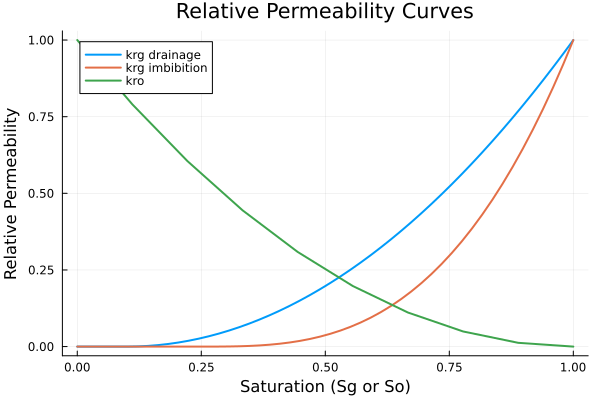

In [17]:
# tab_krg_drain = brooks_corey_relperm.(sg, n = 2, residual = 0.1)
# tab_krg_imb = brooks_corey_relperm.(sg, n = 3, residual = 0.25)

# krg_drain  = PhaseRelativePermeability(sg, tab_krg_drain, label = :g)
# krg_imb  = PhaseRelativePermeability(sg, tab_krg_imb, label = :g)

# # fig, ax, plt = lines(sg, tab_krg_drain, label = "krg drainage")
# # lines!(ax, sg, tab_krg_imb, label = "krg imbibition")
# # lines!(ax, 1 .- so, krog_t, label = "kro")
# # axislegend()
# # fig
# # Define a relative permeability variable

using Plots

# Assuming `brooks_corey_relperm` and `PhaseRelativePermeability` are defined functions
tab_krg_drain = brooks_corey_relperm.(sg, n = 2, residual = 0.1)
tab_krg_imb = brooks_corey_relperm.(sg, n = 3, residual = 0.25)

krg_drain = PhaseRelativePermeability(sg, tab_krg_drain, label = :g)
krg_imb = PhaseRelativePermeability(sg, tab_krg_imb, label = :g)

# Plot the drainage curve
plot(sg, tab_krg_drain, label="krg drainage", linewidth=2)

# Add the imbibition curve
plot!(sg, tab_krg_imb, label="krg imbibition", linewidth=2)

# Add another curve (kro curve as an example)
plot!(1 .- so, krog_t, label="kro", linewidth=2)

# Add legend and display
plot!(xlabel="Saturation (Sg or So)", ylabel="Relative Permeability", title="Relative Permeability Curves")


JutulDarcy uses type instances to define how different variables inside the
simulation are evaluated. The `ReservoirRelativePermeabilities` type has
support for up to three phases with w, ow, og and g relative permeabilities
specified as a function of their respective phases. It also supports
saturation regions.

Note: If regions are used, all drainage curves come first followed by equal
number of imbibition curves. Since we only have a single (implicit) saturation
region, the krg input should have two entries: One for drainage, and one for
imbibition.

We also call `add_relperm_parameters` to the model. This makes sure that when
hysteresis is enabled, we track maximum saturation for hysteresis in each
reservoir cell.

In [18]:
import JutulDarcy: KilloughHysteresis, ReservoirRelativePermeabilities
krg = (krg_drain, krg_imb)
H_g = KilloughHysteresis() # Other options: CarlsonHysteresis, JargonHysteresis
relperm = ReservoirRelativePermeabilities(g = krg, og = krog, hysteresis_g = H_g)
replace_variables!(model, RelativePermeabilities = relperm)
add_relperm_parameters!(model);

## Define approximate hydrostatic pressure and set up initial state
The initial pressure of the water-filled domain is assumed to be at
hydrostatic equilibrium. If we use an immiscible model, we must provide the
initial saturations. If we are using a compositional model, we should instead
provide the overall mole fractions. Note that since both are fractions, and
the CO2 model has correspondence between phase ordering and component ordering
(i.e. solves for liquid and vapor, and H2O and CO2), we can use the same input
value.

In [19]:
nc = number_of_cells(mesh)
p0 = zeros(nc)
depth = domain[:cell_centroids][3, :]
g = Jutul.gravity_constant
@. p0 = 160bar + depth*g*1000.0
# fig, ax, plt = plot_cell_data(mesh, p0)
# fig

5000-element Vector{Float64}:
 1.6259817715480573e7
 1.6278662568015259e7
 1.6295612126484213e7
 1.630959379972497e7
 1.6319802013508622e7
 1.63257681861333e7
 1.6327398227492694e7
 1.6324974022933237e7
 1.6319118878498632e7
 1.631073041981455e7
 ⋮
 1.7068522096501365e7
 1.7072473602066763e7
 1.7079856047507305e7
 1.7091292738866698e7
 1.7107065561491378e7
 1.7127080425275028e7
 1.7150868748515785e7
 1.7177624956984743e7
 1.7206276459519424e7

Set up initial state and parameters

In [20]:
if use_immiscible
    state0 = setup_reservoir_state(model,
        Pressure = p0,
        Saturations = [1.0, 0.0],
    )
else
    state0 = setup_reservoir_state(model,
        Pressure = p0,
        OverallMoleFractions = [1.0, 0.0],
    )
end
parameters = setup_parameters(model)

Dict{Symbol, Any} with 3 entries:
  :Injector  => Dict{Symbol, Any}(:FluidVolume=>[0.0630954], :PerforationGravit…
  :Reservoir => Dict{Symbol, Any}(:Transmissibilities=>[2.85521e-14, 2.87444e-1…
  :Facility  => Dict{Symbol, Any}()

## Find the boundary and apply a constant pressureboundary condition
We find cells on the left and right boundary of the model and set a constant
pressure boundary condition to represent a bounding aquifer that retains the
initial pressure far away from injection.

In [21]:
boundary = Int[]
for cell in 1:nc
    I, J, K = cell_ijk(mesh, cell)
    if I == 1 || I == nx
        push!(boundary, cell)
    end
end
bc = flow_boundary_condition(boundary, domain, p0[boundary], fractional_flow = [1.0, 0.0])
println("Boundary condition added to $(length(bc)) cells.")

Boundary condition added to 100 cells.


## Plot the model

In [22]:
# plot_reservoir(model)

## Set up schedule
We set up 25 years of injection and 475 years of migration where the well is
shut. The density of the injector is set to 630 kg/m^3, which is roughly the
density of CO2 at the in-situ conditions.

In [23]:
nstep = 25
nstep_shut = 475
dt_inject = fill(365.0day, nstep)
pv = pore_volume(model, parameters)
inj_rate = 0.075*sum(pv)/sum(dt_inject)

rate_target = TotalRateTarget(inj_rate)
I_ctrl = InjectorControl(rate_target, [0.0, 1.0],
    density = 630.0,
)

InjectorControl{TotalRateTarget{Float64}, Float64, Tuple{Tuple{Int64, Float64}}, Vector{Float64}, Missing}(TotalRateTarget with value 1.084474885844749e-6 [m^3/s], [0.0, 1.0], 630.0, ((1, 1.0),), 293.15, missing, 1.0)

Set up forces for use in injection

In [24]:
controls = Dict(:Injector => I_ctrl)
forces_inject = setup_reservoir_forces(model, control = controls, bc = bc)

Dict{Symbol, Any} with 3 entries:
  :Injector  => (mask = nothing,)
  :Reservoir => (bc = FlowBoundaryCondition{Int64, Float64, Tuple{Float64, Floa…
  :Facility  => (control = Dict{Symbol, InjectorControl{TotalRateTarget{Float64…

Forces with shut wells

In [25]:
forces_shut = setup_reservoir_forces(model, bc = bc)
dt_shut = fill(365.0day, nstep_shut);

Combine the report steps and forces into vectors of equal length

In [26]:
dt = vcat(dt_inject, dt_shut)
forces = vcat(
    fill(forces_inject, nstep),
    fill(forces_shut, nstep_shut)
)
println("$nstep report steps with injection, $nstep_shut report steps with migration.")

25 report steps with injection, 475 report steps with migration.


## Add some more outputs for plotting

In [27]:
rmodel = reservoir_model(model)
push!(rmodel.output_variables, :RelativePermeabilities)
push!(rmodel.output_variables, :PhaseViscosities)

9-element Vector{Symbol}:
 :Pressure
 :OverallMoleFractions
 :TotalMasses
 :LiquidMassFractions
 :VaporMassFractions
 :Saturations
 :PhaseMassDensities
 :RelativePermeabilities
 :PhaseViscosities

## Simulate the schedule
We set a maximum internal time-step of 30 days to ensure smooth convergence
and reduce numerical diffusion.

In [28]:
wd, states, t = simulate_reservoir(state0, model, dt,
    parameters = parameters,
    forces = forces,
    max_timestep = 90day
);

Simulating 499 years, 34.86 weeks as 500 report steps   0%  ETA: 0:35:42

Simulating 499 years, 34.86 weeks as 500 report steps   2%  ETA: 0:09:08

Simulating 499 years, 34.86 weeks as 500 report steps   3%  ETA: 0:08:37

Simulating 499 years, 34.86 weeks as 500 report steps   3%  ETA: 0:08:19

Simulating 499 years, 34.86 weeks as 500 report steps   3%  ETA: 0:08:03

Simulating 499 years, 34.86 weeks as 500 report steps   3%  ETA: 0:07:49

Simulating 499 years, 34.86 weeks as 500 report steps   3%  ETA: 0:07:34

Simulating 499 years, 34.86 weeks as 500 report steps   4%  ETA: 0:07:29

Simulating 499 years, 34.86 weeks as 500 report steps   4%  ETA: 0:07:21

Simulating 499 years, 34.86 weeks as 500 report steps   4%  ETA: 0:07:16

Simulating 499 years, 34.86 weeks as 500 report steps   4%  ETA: 0:07:13

Simulating 499 years, 34.86 weeks as 500 report steps   4%  ETA: 0:07:05

Simulating 499 years, 34.86 weeks as 500 report steps   5%  ETA: 0:06:58

Simulating 499 years, 34.86 weeks as 5

╭────────────────┬───────────┬────────────────┬──────────────╮
│ Iteration type │  Avg/step │   Avg/ministep │        Total │
│                │ 500 steps │ 2570 ministeps │     (wasted) │
├────────────────┼───────────┼────────────────┼──────────────┤
│ Newton         │     9.316 │        1.81245 │   4658 (375) │
│ Linearization  │    14.456 │        2.81245 │   7228 (400) │
│ Linear solver  │    40.544 │        7.88794 │ 20272 (1455) │
│ Precond apply  │    81.088 │        15.7759 │ 40544 (2910) │
╰────────────────┴───────────┴────────────────┴──────────────╯
╭───────────────┬─────────┬────────────┬─────────╮
│ Timing type   │    Each │   Relative │   Total │
│               │      ms │ Percentage │       s │
├───────────────┼─────────┼────────────┼─────────┤
│ Properties    │  1.5868 │    12.41 % │  7.3912 │
│ Equations     │  0.9561 │    11.60 % │  6.9110 │
│ Assembly      │  0.5118 │     6.21 % │  3.6993 │
│ Linear solve  │  0.7482 │     5.85 % │  3.4853 │
│ Linear setup  │  3.0691

## Plot the CO2 mole fraction
We plot the overall CO2 mole fraction. We scale the color range to log10 to
account for the fact that the mole fraction in cells made up of only the
aqueous phase is much smaller than that of cells with only the gaseous phase,
where there is almost just CO2.

The aquifer gives some degree of passive flow through the domain, ensuring
that much of the dissolved CO2 will leave the reservoir by the end of the
injection period.

In [31]:
# using GLMakie
# function plot_co2!(fig, ix, x, title = "")
#     ax = Axis3(fig[ix, 1],
#         zreversed = true,
#         azimuth = -0.51π,
#         elevation = 0.05,
#         aspect = (1.0, 1.0, 0.3),
#         title = title)
#     plt = plot_cell_data!(ax, mesh, x, colormap = :seaborn_icefire_gradient)
#     Colorbar(fig[ix, 2], plt)
# end
# fig = Figure(size = (900, 1200))
# for (i, step) in enumerate([5, nstep, nstep + Int(floor(nstep_shut/2)), nstep+nstep_shut])
#     if use_immiscible
#         plot_co2!(fig, i, states[step][:Saturations][2, :], "CO2 plume saturation at report step $step/$(nstep+nstep_shut)")
#     else
#         plot_co2!(fig, i, log10.(states[step][:OverallMoleFractions][2, :]), "log10 of CO2 mole fraction at report step $step/$(nstep+nstep_shut)")
#     end
# end
# fig



# using Plots

# # Function to plot CO2 data
# function plot_co2!(x, title; use_log=false)
#     if use_log
#         plot3d(
#             mesh, 
#             log10.(x), 
#             color=:seaborn_icefire_gradient, 
#             xlabel="X", ylabel="Y", zlabel="Z",
#             title=title, lw=0.4
#         )
#     else
#         plot3d(
#             mesh, 
#             x, 
#             color=:seaborn_icefire_gradient, 
#             xlabel="X", ylabel="Y", zlabel="Z",
#             title=title, lw=0.4
#         )
#     end
# end

# # Array to store individual plots
# plots = []

# # Create each plot and store them
# for (i, step) in enumerate([5, nstep, nstep + Int(floor(nstep_shut/2)), nstep + nstep_shut])
#     if use_immiscible
#         push!(
#             plots, 
#             plot_co2!(states[step][:Saturations][2, :], "CO2 plume saturation at report step $step/$(nstep + nstep_shut)")
#         )
#     else
#         push!(
#             plots, 
#             plot_co2!(states[step][:OverallMoleFractions][2, :], "log10 of CO2 mole fraction at report step $step/$(nstep + nstep_shut)", use_log=true)
#         )
#     end
# end

# # Combine all the subplots into a grid layout
# plot(plots..., layout=(4, 1), size=(900, 1200))


## Plot all relative permeabilities for all time-steps
We can plot all relative permeability evaluations. This both verifies that the
hysteresis model is active, but also gives an indication to how many cells are
exhibiting imbibition during the simulation.

In [32]:
# kro_val = Float64[]
# krg_val = Float64[]
# sg_val = Float64[]
# for state in states
#     kr_state = state[:RelativePermeabilities]
#     s_state = state[:Saturations]
#     for c in 1:nc
#         push!(kro_val, kr_state[1, c])
#         push!(krg_val, kr_state[2, c])
#         push!(sg_val, s_state[2, c])
#     end
# end

# fig = Figure()
# ax = Axis(fig[1, 1], title = "Relative permeability during simulation")
# fig, ax, plt = scatter(sg_val, kro_val, label = "kro", alpha = 0.3)
# scatter!(ax, sg_val, krg_val, label = "krg", alpha = 0.3)
# axislegend()
# fig


# using Plots

# # Initialize arrays to store relative permeabilities and saturations
# kro_val = Float64[]
# krg_val = Float64[]
# sg_val = Float64[]

# # Extract relative permeability and saturation data
# for state in states
#     kr_state = state[:RelativePermeabilities]
#     s_state = state[:Saturations]
#     for c in 1:nc
#         push!(kro_val, kr_state[1, c])
#         push!(krg_val, kr_state[2, c])
#         push!(sg_val, s_state[2, c])
#     end
# end

# # Plot relative permeability data
# scatter(
#     sg_val, kro_val, 
#     label = "kro", 
#     alpha = 0.3, 
#     xlabel = "Sg", 
#     ylabel = "Relative Permeability", 
#     title = "Relative permeability during simulation"
# )

# # Add krg data to the same plot
# scatter!(
#     sg_val, krg_val, 
#     label = "krg", 
#     alpha = 0.3
# )

# # Show the plot with a legend
# plot!()


## Plot result in interactive viewer
If you have interactive plotting available, you can explore the results
yourself.

In [33]:
# plot_reservoir(model, states)
# Calculate and display inventory of CO2

We can classify and plot the status of the CO2 in the reservoir. We use a
fairly standard classification where CO2 is divided into:

- dissolved CO2 (dissolution trapping)
- residual CO2 (immobile due to zero relative permeability, residual trapping)
- mobile CO2 (mobile but still inside domain)
- outside domain (left the simulation model and migrated outside model)

We also note that some of the mobile CO2 could be considered to be
structurally trapped, but this is not classified in our inventory.

In [36]:
Pkg.status("JutulDarcy")

Status `/localdata/hli853/SLIM-tutorials/04-Intro-Jutul/Project.toml`
  [82210473] JutulDarcy v0.2.36


In [45]:
inventory = co2_inventory(model, wd, states, t)
# JutulDarcy.plot_co2_inventory(t, inventory)

500-element Vector{Dict{Symbol, Float64}}:
 Dict(:mobile => 0.0, :dissolved => 8003.783870398425, :outside_domain => 25.188692814470414, :produced => 0.0, :outside_total => -7.275957614183426e-12, :inside_total => 21520.811307185537, :residual => 13517.027436787113, :injected => 21546.0, :domain_total => 21520.81130718553)
 Dict(:mobile => 0.0, :dissolved => 16222.694240417317, :outside_domain => 26.456628477521008, :produced => 0.0, :outside_total => 7.275957614183426e-12, :inside_total => 43065.54337152247, :residual => 26842.849131105144, :injected => 43092.0, :domain_total => 43065.54337152248)
 Dict(:mobile => 524.9964668319568, :dissolved => 24611.91295003866, :outside_domain => 26.0403152796207, :produced => 0.0, :outside_total => 4.3655745685100555e-11, :inside_total => 64611.959684720336, :residual => 39475.05026784971, :injected => 64638.0, :domain_total => 64611.95968472038)
 Dict(:mobile => 1463.496292599204, :dissolved => 32312.052138789033, :outside_domain => 25.996676614

## Pick a region to investigate the CO2
We can also specify a region to the CO2 inventory. This will introduce
additional categories to distinguish between outside and inside the region of
interest.

In [46]:
cells = findall(region .== 2)
inventory = co2_inventory(model, wd, states, t, cells = cells)
# JutulDarcy.plot_co2_inventory(t, inventory)

500-element Vector{Dict{Symbol, Float64}}:
 Dict(:mobile => 0.0, :dissolved => 5601.152883246145, :outside_domain => 25.188692814470414, :produced => 0.0, :outside_total => 7596.22451300801, :inside_total => 13924.58679417752, :residual => 8323.433910931384, :injected => 21546.0, :domain_total => 21520.81130718553)
 Dict(:mobile => 0.0, :dissolved => 12410.071280387243, :outside_domain => 26.456628477521008, :produced => 0.0, :outside_total => 11785.823298068386, :inside_total => 31279.720073454093, :residual => 18869.64879306686, :injected => 43092.0, :domain_total => 43065.54337152248)
 Dict(:mobile => 0.0, :dissolved => 19029.716829859473, :outside_domain => 26.0403152796207, :produced => 0.0, :outside_total => 16921.76987040136, :inside_total => 47690.18981431902, :residual => 28660.472984459517, :injected => 64638.0, :domain_total => 64611.95968472038)
 Dict(:mobile => 0.0, :dissolved => 22500.94111181409, :outside_domain => 25.99667661404237, :produced => 0.0, :outside_total => 3

## Define a region of interest using geometry
Another alternative to determine a region of interest is to use geometry. We
pick all cells within an ellipsoid a bit away from the injection point.

In [49]:
is_inside = fill(false, nc)
centers = domain[:cell_centroids]
for cell in 1:nc
    x, y, z = centers[:, cell]
    is_inside[cell] = sqrt((x - 720.0)^2 + 20*(z-70.0)^2) < 75
end
# fig, ax, plt = plot_cell_data(mesh, is_inside)
# fig

## Plot inventory in ellipsoid
Note that a small mobile dip can be seen when free CO2 passes through this region.

In [50]:
inventory = co2_inventory(model, wd, states, t, cells = findall(is_inside))
# JutulDarcy.plot_co2_inventory(t, inventory)

500-element Vector{Dict{Symbol, Float64}}:
 Dict(:mobile => 0.0, :dissolved => 4212.5925951333675, :outside_domain => 25.188692814470414, :produced => 0.0, :outside_total => 10794.283034675827, :inside_total => 10726.528272509702, :residual => 6513.935677376337, :injected => 21546.0, :domain_total => 21520.81130718553)
 Dict(:mobile => 0.0, :dissolved => 10477.585083202473, :outside_domain => 26.456628477521008, :produced => 0.0, :outside_total => 14954.91573489143, :inside_total => 28110.62763663105, :residual => 17633.042553428557, :injected => 43092.0, :domain_total => 43065.54337152248)
 Dict(:mobile => 0.0, :dissolved => 16766.83781659627, :outside_domain => 26.0403152796207, :produced => 0.0, :outside_total => 20245.000933628304, :inside_total => 44366.958751092076, :residual => 27600.12093449581, :injected => 64638.0, :domain_total => 64611.95968472038)
 Dict(:mobile => 0.0, :dissolved => 22723.428591858334, :outside_domain => 25.99667661404237, :produced => 0.0, :outside_total 

## Plot the average pressure in the ellipsoid region
Now that we know what cells are within the region of interest, we can easily
apply a function over all time-steps to figure out what the average pressure
value was.

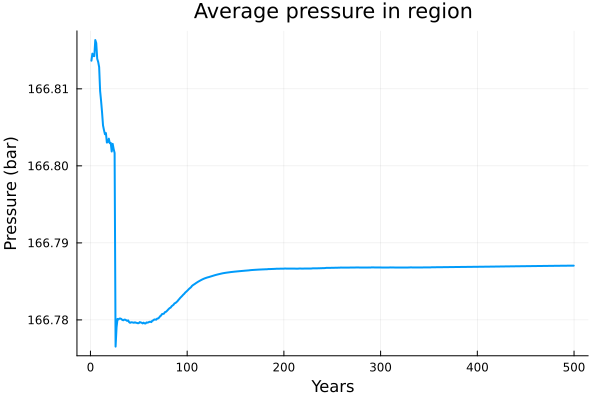

In [51]:
# using Statistics
# p_avg = map(
#     state -> mean(state[:Pressure][is_inside])./bar,
#     states
# )
# lines(t./yr, p_avg,
#     axis = (
#         title = "Average pressure in region",
#         xlabel = "Years", ylabel = "Pressure (bar)"
#     )
# )

using Statistics
using Plots

# Calculate the average pressure in the region for each state
p_avg = map(
    state -> mean(state[:Pressure][is_inside]) / bar,
    states
)

# Plot the average pressure over time
plot(
    t ./ yr, p_avg,
    label = "",
    xlabel = "Years",
    ylabel = "Pressure (bar)",
    title = "Average pressure in region",
    linewidth = 2
)


## Make a composite plot to correlate CO2 mass in region with spatial distribution
We create a pair of plots that combine both 2D and 3D plots to simultaneously
show the ellipsoid, the mass of CO2 in that region for a specific step, and
the time series of the CO2 in the same region.

In [54]:
# stepno = 30
# co2_mass_in_region = map(
#     state -> sum(state[:TotalMasses][2, is_inside])/1e3,
#     states
# )
# fig = Figure(size = (1200, 600))
# ax1 = Axis(fig[1, 1],
#     title = "Mass of CO2 in region",
#     xlabel = "Years",
#     ylabel = "Tonnes CO2"
# )
# lines!(ax1, t./yr, co2_mass_in_region)
# scatter!(ax1, t[stepno]./yr, co2_mass_in_region[stepno], markersize = 12, color = :red)
# ax2 = Axis3(fig[1, 2], zreversed = true)
# plot_cell_data!(ax2, mesh, states[stepno][:TotalMasses][2, :])
# plot_mesh!(ax2, mesh, cells = findall(is_inside), alpha = 0.5)
# ax2.azimuth[] = 1.5*π
# ax2.elevation[] = 0.0
# fig





# using Plots

# # Calculate CO2 mass in the region for each state
# co2_mass_in_region = map(
#     state -> sum(state[:TotalMasses][2, is_inside]) / 1e3,
#     states
# )

# # Define time and step for annotation
# stepno = 30

# # Plot mass of CO2 in the region over time
# plot(
#     t ./ yr, co2_mass_in_region,
#     label = "CO2 Mass",
#     xlabel = "Years",
#     ylabel = "Tonnes CO2",
#     title = "Mass of CO2 in Region",
#     linewidth = 2
# )

# # Highlight a specific point (stepno) with a red marker
# scatter!(
#     [t[stepno] ./ yr], [co2_mass_in_region[stepno]],
#     color = :red,
#     markersize = 8,
#     label = "Step $stepno"
# )

# # Add a 3D plot for CO2 distribution at a specific step
# plot3d(
#     mesh, 
#     states[stepno][:TotalMasses][2, :],
#     marker_z=states[stepno][:TotalMasses][2, :], 
#     color=:viridis,
#     xlabel="X",
#     ylabel="Y",
#     zlabel="Z",
#     title="CO2 Distribution (Step $stepno)"
# )



## Paper link:

https://www.earthdoc.org/content/papers/10.3997/2214-4609.202437111

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*